<div style="width: 100%; clear: both;">
<div style="float: left; width: 50%;">
<img src="http://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/UOC_Masterbrand.jpg", align="left">
</div>
<div style="float: right; width: 50%;">
<p style="margin: 0; padding-top: 22px; text-align:right;">M2.955 · Models avançats de mineria de dades</p>
<p style="margin: 0; text-align:right;">2022-2 · Màster universitari en Ciència de dades (Data science)</p>
<p style="margin: 0; text-align:right; padding-button: 100px;">Estudis d'Informàtica, Multimèdia i Telecomunicació</p>
</div>
</div>
<div style="width:100%;">&nbsp;</div>

# PAC 2: Mètodes no supervisats

Al llarg d'aquesta pràctica veurem com aplicar diferents tècniques no supervisades, així com algunes de les seves aplicacions reals:

 - **[Clustering amb diferents estratègies](#ej1)**: k-means i regla del colze, basades en densitat i jeràrquiques.
 - **[Aplicació per comprimir imatges](#ej2)**: clustering i anàlisi.
 - **[Aplicació de reducció de dimensionalitat per resoldre un problema d'optimització](#ej3)**: t-SNE.

<u>Consideracions generals</u>: 

- La solució plantejada no pot utilitzar mètodes, funcions o paràmetres declarats **_deprecated_** en futures versions, llevat que s'indiqui explícitament.
- Aquesta PAC s'ha de fer de manera **estrictament individual**. Qualsevol indici de còpia serà penalitzat amb un suspens (D) per a totes les parts implicades i la possible avaluació negativa de l'assignatura de forma íntegra.
- Cal que l'estudiant indiqui **totes les fonts** que ha fet servir per a la realització de la PAC. Si no és així, es considerarà que l'estudiant ha comès plagi, i és penalitzat amb un suspens (D) i la possible avaluació negativa de l'assignatura de forma íntegra.

<u>Format del lliurament</u>:

- Alguns exercicis poden suposar diversos minuts d'execució, per la qual cosa el lliurament s'ha de fer a format notebook ia format HTML, on es vegi el codi, els resultats i comentaris de cada exercici. Es pot exportar el notebook a HTML des del menú File $\to$ Download as $\to$ HTML.
- Hi ha un tipus de cel·la especial per allotjar text. Aquest tipus de cel·la us serà molt útil per respondre les diferents preguntes teòriques plantejades al llarg de lactivitat. Per canviar el tipus de cel·la a aquest tipus, al menú: Cell $\to$ Cell Type $\to$ Markdown.

<div class="alert alert-block alert-info">
<strong>Nom i cognoms:</strong>
</div>

Iniciem l'activitat amb la càrrega de les llibreries següents:

In [1]:
import random

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
from sklearn import cluster        # Algorismes de clustering.
from sklearn import datasets       # Crear datasets.

%matplotlib inline

<a id="ej1"></a>

## 1. Mètodes de *clustering* (5 punts)

Aquest exercici intenta explorar diferents tècniques d'agrupament, ajustant-les a diferents conjunts de dades.

L'objectiu és doble:
- entendre la influència dels paràmetres en el seu comportament,
- i conèixer-ne les limitacions en la recerca d'estructures de dades.

### Generació dels conjunts de dades

In [2]:
X_blobs, y_blobs = datasets.make_blobs(n_samples=1000, n_features=2, centers=4, cluster_std=1.6, random_state=42)
X_moons, y_moons = datasets.make_moons(n_samples=1000, noise=.07, random_state=42)
X_circles, y_circles = datasets.make_circles(n_samples=1000, factor=.5, noise=.05, random_state=42)

Cada dataset té 2 variables: una variable X que conté 2 features (columnes) i tantes files com mostres. I una variable y que conté les etiquetes que identifiquen cada cluster.

Al llarg de l'exercici no s'usarà la variable y (només amb l'objectiu de visualitzar). L'objectiu és aconseguir trobar les estructures descrites per les variables y a través dels diferents models de clustering.

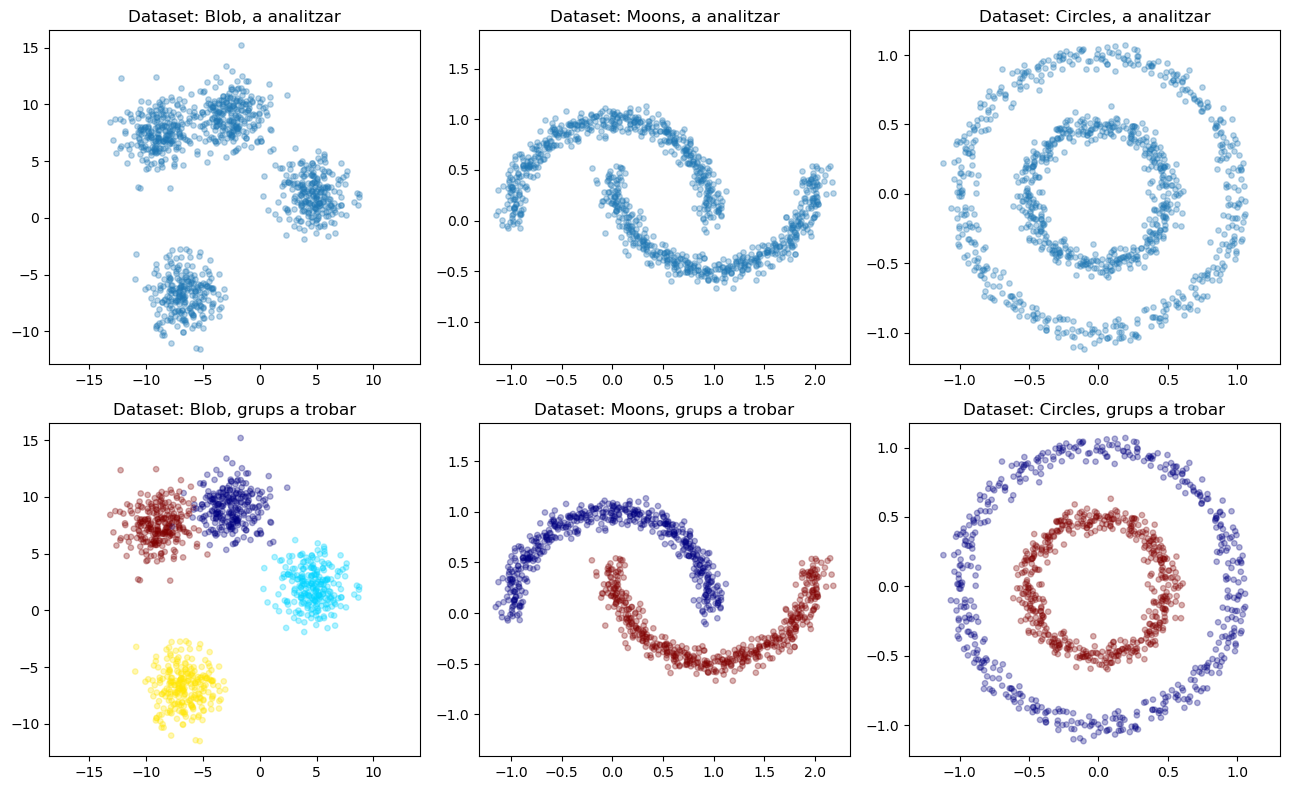

In [3]:
fig, axis = plt.subplots(2, 3, figsize=(13, 8))
for i, (X, y, ax, name) in enumerate(zip([X_blobs, X_moons, X_circles] * 2,
                                         [None] * 3 + [y_blobs, y_moons, y_circles],
                                         axis.reshape(-1),
                                         ['Blob', 'Moons', 'Circles'] * 2)):
    ax.set_title('Dataset: {}, '.format(name) + ('a analitzar' if i < 3 else 'grups a trobar'))
    ax.scatter(X[:,0], X[:,1], s=15, c=y, alpha=.3, cmap='jet')
    ax.axis('equal')
plt.tight_layout()

### 1 a. K-means

En aquest apartat es demana provar l'algorisme k-means sobre els tres datasets presentats anteriorment, ajustant els paràmetres, i analitzar els seus resultats.

In [4]:
X, y = X_blobs, y_blobs

Es demana estimar el nombre de clústers a detectar per *k-means*. Una tècnica per estimar $k$ és, com s'explica a la teoria:
> Els criteris anteriors (minimització de distàncies intra grup o maximització de distàncies inter grup) poden usar-se per establir un valor adequat per al paràmetre k. Valors k per als quals ja no s'aconsegueixen millores significatives en l'homogeneïtat interna dels segments o l'heterogeneïtat entre segments diferents, haurien de descartar-se.

El que popularment es coneix com *regla del colze*.

Primer cal calcular la suma dels errors quadràtics ([*SSE*](https://bl.ocks.org/rpgove/0060ff3b656618e9136b)) que consisteix en la suma de tots els errors (distància de cada punt al seu centroide assignat) al quadrat.

$$SSE = \sum_{i=1}^{K} \sum_{x \in C_i} euclidean(x, c_i)^2$$

On $K$ és el nombre de clústers a buscar per *k-means*, $x \in C_i$ són els punts que pertanyen a l'i-èsim clúster, $c_i $ és el centroide del clúster $C_i$ (al que pertany el punt $x$), i $euclidean$ és la [distància euclidiana](https://en.wikipedia.org/wiki/Euclidean_distance).

Aquest procediment realitzat per a cada possible valor $k$, resulta en una funció monòtona decreixent on l'eix $x$ representa els diferents valors de $k$, i l'eix $i$ el $SSE$. Intuïtivament es podrà observar un significatiu descens de l'error, que indicarà el valor idoni de $ k $.

**Es demana realitzar la representació gràfica de la regla del colze amb la seva interpretació, utilitzant la llibreria ```matplotlib``` i la implementació en scikit-learn de [*k-means*](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html).**

<div class="alert alert-block alert-info">
    <strong>Implementació:</strong> càlcul i visualització de la regla del colze amb el dataset blobs.  
</div>

<div class="alert alert-block alert-info">
<strong>Anàlisi:</strong> què s'interpreta a la gràfica? Com es podria millorar l'elecció de $k$?  
</div>

<div class="alert alert-block alert-info">
<strong>Implementació:</strong> càlcul i visualització dels grups al dataset Blobs.
</div>

<div class="alert alert-block alert-info">
<strong>Anàlisi:</strong> 
Què ha passat? Explica els motius pels quals creus que aquest resultat s'ha produït.
</div>

In [7]:
X, y = X_moons, y_moons

<div class="alert alert-block alert-info">
    <strong>Implementació:</strong> càlcul i visualització de la regla del colze amb el dataset Moons.  
</div>

<div class="alert alert-block alert-info">
<strong>Anàlisi:</strong> Què s'interpreta a la gràfica? Com es podria millorar l'elecció de $k$?  
</div>

<div class="alert alert-block alert-info">
<strong>Implementació:</strong> càlcul i visualització dels grups al dataset Moons.
</div>

<div class="alert alert-block alert-info">
<strong>Anàlisi:</strong> 
Què ha passat? Explica els motius pels quals creus que aquest resultat s'ha produït.
</div>

In [10]:
X, y = X_circles, y_circles

<div class="alert alert-block alert-info">
    <strong>Implementació:</strong> càlcul i visualització de la regla del colze amb el dataset Circles.  
</div>

<div class="alert alert-block alert-info">
<strong>Anàlisi:</strong> Què s'interpreta a la gràfica? Com es podria millorar l'elecció de $k$?  
</div>

<div class="alert alert-block alert-info">
<strong>Implementació:</strong> càlcul i visualització dels grups al dataset Circles.
</div>

<div class="alert alert-block alert-info">
<strong>Anàlisi:</strong> 
Què ha passat? Explica els motius pels quals creus que aquest resultat s'ha produït.
</div>

### 1 b. Algorismes basats en densitat: DBSCAN

En aquest apartat es demana aplicar clustering per densitat com [DBSCAN](https://en.wikipedia.org/wiki/DBSCAN) al conjunt de dades anterior per a poder trobar els clústers subjacents.

Aquesta és una visualització intuïtiva del funcionament: https://www.youtube.com/watch?v=RDZUdRSDOok

In [13]:
X, y = X_blobs, y_blobs

<div class="alert alert-block alert-info">
<strong> Implementació: </strong> prova la implementació de <a href="http://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html"> DBSCAN en scikit-learn</a> jugant amb els paràmetres <i> eps </i> i <i> min_samples </i> per trobar les estructures subjacents (i <i> outliers</i>).
</div>

<div class="alert alert-block alert-info">
<strong> Anàlisi: </strong> Què ha passat? Explica els motius pels quals creus que s'ha produït aquest resultat.
</div>

In [15]:
X, y = X_moons, y_moons

<div class="alert alert-block alert-info">
<strong> Implementació: </strong> prova la implementació de <a href="http://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html"> DBSCAN en scikit-learn</a> jugant amb els paràmetres <i> eps </i> i <i> min_samples </i> per trobar les estructures subjacents (i <i> outliers</i>).
</div>

<div class="alert alert-block alert-info">
<strong> Anàlisi: </strong> Què ha passat? Explica els motius pels quals creus que s'ha produït aquest resultat.
</div>

In [17]:
X, y = X_circles, y_circles

<div class="alert alert-block alert-info">
<strong> Implementació: </strong> prova la implementació de <a href="http://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html"> DBSCAN en scikit-learn</a> jugant amb els paràmetres <i> eps </i> i <i> min_samples </i> per trobar les estructures subjacents (i <i> outliers</i>).
</div>

<div class="alert alert-block alert-info">
<strong> Anàlisi: </strong> Què ha passat? Explica els motius pels quals creus que s'ha produït aquest resultat.
</div>

### 1 c. Algorismes jeràrquics

En aquest apartat es demana visualitzar mitjançant un [dendrograma](https://en.wikipedia.org/wiki/Dendrogram) la construcció progressiva dels grups mitjançant un algorisme jeràrquic aglomeratiu (estratègia *bottom-up*). Amb això es pretén trobar un mètode gràfic per entendre el comportament de l'algorisme i trobar els clústers.

In [19]:
X, y = X_blobs, y_blobs

<div class="alert alert-block alert-info">
    <strong>Implementació:</strong> prova la implementació de <a href="https://docs.scipy.org/doc/scipy/reference/cluster.hierarchy.html"> clustering jeràrquic de SciPy </a> provant diferents <a href = "https://en.wikipedia.org/wiki/Hierarchical_clustering#Linkage_criteria">criteris d'enllaç o <i> linkage </i> </a> permetent identificar els clústers subjacents (mostrant el seu resultat) i la seva dendrograma.<br>
Pots importar les llibreries necessàries per fer-ho.
</div>

<div class="alert alert-block alert-info">
<strong>Anàlisi: </strong> Interpreta el dendrograma i comenta quin criteri d'enllaç s'ha comportat millor. Per què?
</div>

In [21]:
X, y = X_moons, y_moons

<div class="alert alert-block alert-info">
    <strong>Implementació:</strong> prova la implementació de <a href="https://docs.scipy.org/doc/scipy/reference/cluster.hierarchy.html"> clustering jeràrquic de SciPy </a> provant diferents <a href = "https://en.wikipedia.org/wiki/Hierarchical_clustering#Linkage_criteria">criteris d'enllaç o <i> linkage </i> </a> permetent identificar els clústers subjacents (mostrant el seu resultat) i la seva dendrograma.<br>
Pots importar les llibreries necessàries per fer-ho.
</div>

<div class="alert alert-block alert-info">
<strong>Anàlisi: </strong> Interpreta el dendrograma i comenta quin criteri d'enllaç s'ha comportat millor. Per què?
</div>

In [23]:
X, y = X_circles, y_circles

<div class="alert alert-block alert-info">
    <strong>Implementació:</strong> prova la implementació de <a href="https://docs.scipy.org/doc/scipy/reference/cluster.hierarchy.html"> clustering jeràrquic de SciPy </a> provant diferents <a href = "https://en.wikipedia.org/wiki/Hierarchical_clustering#Linkage_criteria">criteris d'enllaç o <i> linkage </i> </a> permetent identificar els clústers subjacents (mostrant el seu resultat) i la seva dendrograma.<br>
Pots importar les llibreries necessàries per fer-ho.
</div>

<div class="alert alert-block alert-info">
<strong>Anàlisi: </strong> Interpreta el dendrograma i comenta quin criteri d'enllaç s'ha comportat millor. Per què?
</div>

<a id="ej2"></a>

## 2. Aplicació per comprimir imatges (3 punts)

Les imatges en color es componen de píxels que tenen tres components (vermella, blau i verd), destinant 1 *byte* a cada canal. Podent representar $2^8 = 256$ vermells, verds i blaus. Amb un total de $2^{8^{3}} = 2^{24} = 16777216$ colors representables a cada píxel.

Com més gran sigui el nombre de colors representables, més memòria serà necessària per emmagatzemar la imatge.
Per tant, una estratègia per comprimir una imatge pot ser disminuir els colors representables a cada píxel, necessitant menys bits per guardar el valor d'un píxel. Aquest mètode no és reversible, és a dir, no es pot tornar a recuperar la imatge original a partir de la comprimida. Per tant, aquest tipus de compressió s'anomena [comprensió amb pèrdues](https://es.wikipedia.org/wiki/Algoritmo_de_compresi%C3%B3n_con_p%C3%A9rdida).

Però com seleccionem els "píxels semblants" a la imatge original i determinem el seu color a la imatge comprimida? Una opció és utilitzar *k-means* on **$k$ serà el nombre de colors representables**, els punts que pertanyen a cada cluster equivaldrien als "píxels semblants" i les coordenades dels **centroides actuaran com els colors finals** als quals s'aproximaran els "píxels semblants".

Com a resultat del clustering, s'obté una paleta de colors reduïda (coordenades dels centroides) on cada píxel de la imatge farà referència a un d'aquests colors (cluster a què pertany). L'ús de paletes de colors o [colors indexats](https://en.wikipedia.org/wiki/Indexed_color) és un recurs emprat per diferents formats d'imatge com *PNG*, *GIF* o *TIFF*.

Si no disposes de la llibreria ``skimage`` pots instal·lar-la:
 - Usant conda (si has creat el teu entorn virtual amb conda): ``conda install scikit-image``
 - Usant pip: ``pip install scikit-image``

Imatge amb 65536 píxels (196608 bytes)


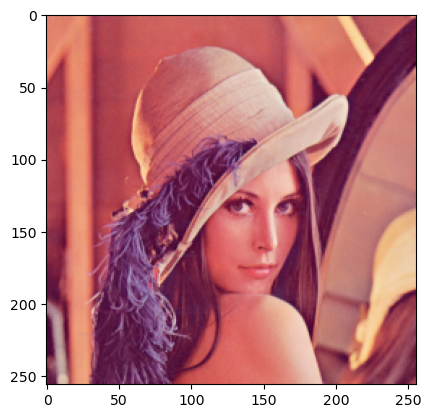

In [25]:
from skimage import io, transform

photo = (transform.resize(
    io.imread('https://upload.wikimedia.org/wikipedia/en/7/7d/Lenna_%28test_image%29.png'),
    (256, 256), mode='edge') * 255).astype(np.uint8)
plt.imshow(photo)        # np.array con shape (256, 256, 3), alto por ancho por 3 (los tres canales: rojo, verde y azul), donde cada valor ocupa un byte.
X = photo.reshape(-1, 3) # np.array con shape (65536, 3), cada pixel con sus 3 canales
print('Imatge amb {} píxels ({} bytes)'.format(X.shape[0], X.shape[0] * 3))

Per facilitar la tasca, la imatge anterior està guardada en un *array* amb tantes files com píxels i columnes com a canals (vermell, verd i blau). De manera que cada "mostra" equival al valor d'un píxel.

Es pot tornar a recompondre la imatge original amb:
```
plt.imshow(X.reshape(photo.shape))
```
Podem veure cada píxel com un punt en un sistema de coordenades de 3 dimensions on una és la quantitat de vermell, una altra la quantitat de verd i finalment la quantitat de blau. Per això podem realitzar una visualització en 3 dimensions dels píxels sobre la qual es provarà l'algorisme de clustering:

In [26]:
X

array([[225, 136, 125],
       [223, 136, 129],
       [225, 133, 118],
       ...,
       [166,  69,  84],
       [177,  68,  78],
       [182,  72,  80]], dtype=uint8)

Per visualitzar l'animació de la representació 3D dels píxels cal instal·lar la llibreria `ffmpeg`.

Si tens un entorn virtual de Conda, el pots instal·lar amb: `conda install -c conda-forge ffmpeg`.

**Si obtens un error**, pots veure una representació estàtica 2 cel·les més endavant.

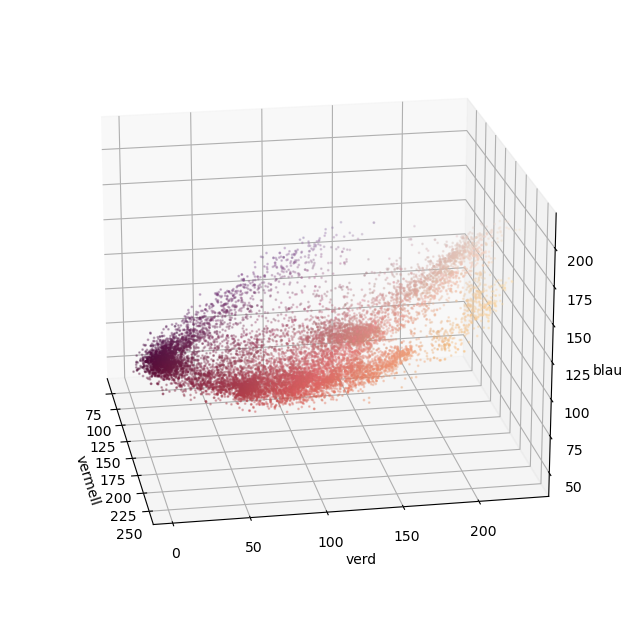

In [27]:
from matplotlib import animation
from mpl_toolkits.mplot3d import Axes3D

matplotlib.rcParams['animation.html'] = 'html5'

idx = np.random.randint(X.shape[0], size=int(X.shape[0] * .2))
fig = plt.figure(figsize=(8, 6))
ax = Axes3D(fig)
ax.scatter(X[idx,0], X[idx,1], X[idx,2], s=1, c=X[idx,:] / 255, alpha=.3)
ax.set_xlabel('vermell')
ax.set_ylabel('verd')
ax.set_zlabel('blau')

def animate(i):
    ax.view_init(elev=20., azim=i)
    return fig,

anim = animation.FuncAnimation(fig, animate, frames=range(0, 360, 10), interval=200, blit=True)
anim

Visualització estàtica del valor dels píxels:

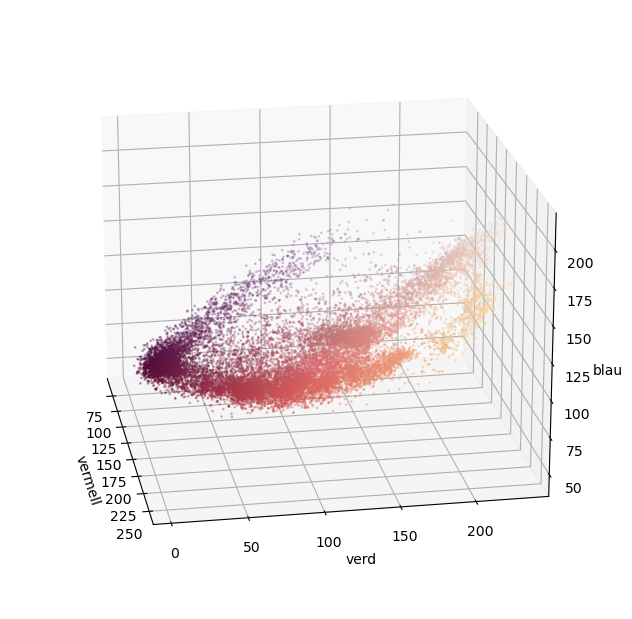

In [28]:
idx = np.random.randint(X.shape[0], size=int(X.shape[0] * .3))
fig = plt.figure(figsize=(8, 6))
ax = Axes3D(fig)
ax.scatter(X[idx,0], X[idx,1], X[idx,2], s=1, c=X[idx,:] / 255, alpha=.3)
ax.set_xlabel('vermell')
ax.set_ylabel('verd')
ax.set_zlabel('blau')
ax.view_init(20, 350)
plt.show()

A la visualització anterior s'ha representat cada píxel amb el seu color, on les coordenades en els 3 colors oscil·len entre 0 (manca d'aquesta component) i 1. Podem comprovar com els píxels en coordenades (255, 255, 255) són píxels blancs i els situats a (0, 0, 0) són píxels negres. També s'observen 4 estructures de píxels: la ploma del barret, el barret, la pell de la model (Lenna) i el fons.

<div class="alert alert-block alert-info">
<strong>Implementació:</strong> aplicar <i>k-means</i> amb <i>k=3</i> als píxels de la imatge (punts amb 3 dimensions de la variable <i>X</i>) i obtenir-ne, per a cada punt, el centroide més proper. I les coordenades (3 dimensions) de cada centroide.
</div>

<div class="alert alert-block alert-info">
<strong>Implementació:</strong> assigna a cada punt (píxel de la imatge) el valor del seu centroide associat en lloc del propi valor.
</div>

<div class="alert alert-block alert-info">
<strong>Implementació:</strong> tornar a convertir el resultat en una imatge usant la funció <i>reshape</i> (com quan es va crear X) perquè torni a tenir la seva dimensió de <i>256 x 256</i>. I mostrar-la amb <i>imshow</i>.
</div>

<div class="alert alert-block alert-info">
<strong>Anàlisi:</strong> per què s'ha produït aquest resultat? quina relació té amb el clústering?
</div>

<div class="alert alert-block alert-info">
<strong>Implementació:</strong> realitzar el procés anterior per a diferents valors de <i>k</i>: 256, 128, 64, 32, 16, 8, 4 i 2 colors. Mostrar les imatges i indicar els bytes que ocuparia cadascuna de les opcions.
</div>

<a id="ej3"></a>

## 3. Aplicació de reducció de dimensionalitat per resoldre un problema d'optimització: t-SNE (2 punts)

Com ja hem vist, l'algorisme [t-SNE](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding) ideat per [van der Maaten i Hinton](https://lvdmaaten.github.io/tsne/) difereix de PCA en què no tracta de maximitzar la variància explicada. Intuïtivament, t-SNE tracta que el veïnatge d'un punt en baixa dimensionalitat sigui el mateix que l'original (mantingueu les distàncies). Partint d'una localització aleatòria de cada punt, corregeix la seva posició de manera iterativa tractant de minimitzar la distància als veïns originals fins a convergir.

Per això, t-SNE disposa de diversos [paràmetres](https://distill.pub/2016/misread-tsne/) que poden modificar dràsticament el resultat. Per això es recomana conèixer-ne el funcionament abans d'aplicar la tècnica.

Partint de les distàncies entre les [províncies d'Espanya](https://www.gifex.com/images/0X0/2009-12-02-11305/Provincias_de_Espana.jpg), presents al fitxer de dades (en *pec2_3.p* un *DataFrame* de *pandas* en format *pickle* o *pec2_3.csv* en format *CSV*). Es demana calcular la matriu quadrada que contingui la distància de cada província contra les altres.

<div class="alert alert-block alert-info">
<strong>Implementació:</strong> la matriu ha de tenir tantes files i columnes com a províncies. I cada cel·la ha de contenir la distància entre les províncies de la fila i la columna.
</div>

Quan es compta amb la matriu de distàncies, *t-SNE* tractarà de mantenir aquestes distàncies entre els diferents punts en baixa dimensionalitat (en aquest cas 2 dimensions), emplaçant els punts al pla mentre intenta mantenir les distàncies indicades.

Atès que l'entrada a [*t-SNE*](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) se li passa la matriu de distàncies, no cal que les calculeu. Per això us indicarem que la mètrica a emprar és "precalculada".

Com a *t-SNE* és un algorisme estocàstic (dues execucions consecutives amb les mateixes dades poden conduir a resultats diferents). Es demana realitzar el procés d'ajust amb *t-SNE* 100 vegades i quedar-se amb l'execució amb menys error (veure l'atribut [*kl_divergence*](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html)).

<div class="alert alert-block alert-info">
<strong>Implementació:</strong> jugar amb els hiperparàmetres de <i>t-SNE</i>, executar 100 vegades l'ajust de <i>t-SNE</i> i desar el resultat d'emplaçament de províncies al pla de l'execució amb menys error.
</div>

Quan es tenen les posicions de les províncies en el pla, visualitzar el resultat i analitzar si l'emplaçament de les províncies calculat per *t-SNE* calculat sobre la base de les distàncies s'assembla al real.

<div class="alert alert-block alert-info">
<strong>Implementació:</strong> visualitzar en un <i>scatter</i> les províncies de l'execució amb menys error, juntament amb el nom per poder analitzar-lo.
</div>

<div class="alert alert-block alert-info">
<strong>Anàlisi:</strong> Existeix similitud amb la distribució de províncies real?, per què?
</div>